# AI agent memory with Redis

Modern AI agents face a fundamental limitation: they operate in isolation, treating each conversation as an entirely new interaction without any recollection of past exchanges or learned user preferences. This creates a frustrating user experience where agents repeatedly ask for the same information and fail to build upon previous interactions.

The solution lies in implementing memory systems that mirror human cognitive architecture. Just as humans maintain both working memory (for immediate tasks) and long-term memory (for accumulated knowledge and experiences), AI agents need dual memory systems to become truly intelligent and personalized.

This notebook demonstrates a practical, production-minded pattern for dual-memory agents: short-term memory for immediate context (what just happened in the conversation) and long-term memory for persistent facts (user preferences, episodic experiences, and domain knowledge). We will implement both episodic memory (personal experiences and preferences) and semantic memory (general knowledge), while managing conversation context efficiently to prevent information overload.

We will use Redis for fast storage and indexing, LangGraph (and its checkpointer) for short-term check-pointing in agent pipelines, and a vector-enabled Redis client for semantic search.


### Dual memory systems
Our system implements two complementary memory types that work together to create intelligent, context-aware agents.

#### Short-term memory (working memory)
- Manages immediate conversation context and temporary state
- Implemented using LangGraph's checkpointer with Redis backend
- Automatically summarizes long conversations to prevent context overflow
- Enables agents to maintain coherent dialogue within sessions

#### Long-term memory (persistent knowledge)
- Stores accumulated knowledge across all interactions
- Uses vector embeddings for semantic similarity search
- Categorized into episodic (personal) and semantic (general) knowledge
- Enables personalization and continuous learning

In [ ]:
# Install required packages
%pip install langchain-openai langgraph-checkpoint langgraph langgraph-checkpoint-redis langchain-redis

In [2]:
import os
from redis import Redis
import getpass
import ulid
from datetime import datetime
from enum import Enum
from typing import List, Optional, Union, Dict
from pydantic import BaseModel, Field
from redisvl.index import SearchIndex
from redisvl.schema.schema import IndexSchema
from redisvl.utils.vectorize.text.openai import OpenAITextVectorizer
from redisvl.query import VectorRangeQuery
from redisvl.query.filter import Tag
import logging
from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig
from langchain_core.messages import AIMessage, SystemMessage, HumanMessage, ToolMessage, RemoveMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt.chat_agent_executor import create_react_agent
from langgraph.checkpoint.redis import RedisSaver
from langgraph.graph.message import MessagesState
from langgraph.graph import StateGraph, END
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import Image, display

- `langgraph-checkpoint`: Persistent state management across conversations.
- `langgraph-checkpoint-redis`: Redis backend for checkpoint storage.
- `langchain-redis`: Vector storage and similarity search capabilities.

#### API key configuration
LLM calls require an API key. We avoid hard-coding secrets in notebooks. The small helper below prompts for the key (secure prompt in a Jupyter environment) and stores it in `os.environ` for the current session.

In [ ]:
def _set_env(key: str):
    """
    Securely set environment variables for API access. Prompts for input if the key doesn't already exist in the environment.
    """
    if key not in os.environ:
        # In notebooks we use getpass.getpass to avoid echoing secrets into the output.
        os.environ[key] = getpass.getpass(f"{key}:")

# Configure OpenAI API access for LLM operations and embeddings
_set_env("OPENAI_API_KEY")

### Redis infrastructure setup
Redis serves as the backbone of our memory system, providing both high-performance caching for short-term memory and vector storage capabilities for long-term memory. We will set up a local Redis instance for development, though the same code works with Redis Cloud for production deployments.

The cell below shows a shell snippet that installs and starts `redis-stack-server` on Debian/Ubuntu systems.

In [4]:
%%sh
# Install and configure Redis Stack Server for local development
# Redis Stack includes vector search capabilities needed for semantic memory

curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list

# Update package list and install Redis Stack (includes RedisSearch for vector operations)
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1

# Start Redis as a background daemon
redis-stack-server --daemonize yes

deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


Redis Stack includes RedisSearch and RedisJSON modules that provide native vector search capabilities. This eliminates the need for separate vector databases while maintaining the performance benefits of in-memory operations for frequently accessed data.

Now let's establish Python Redis client and verify our Redis connection:

In [5]:
# Use the environment variable if set, otherwise default to localhost
REDIS_URL = os.getenv("REDIS_URL", "redis://localhost:6379")

# Create and test the Redis client
redis_client = Redis.from_url(REDIS_URL)
redis_client.ping()  # ping() will raise a ConnectionError if Redis is not reachable

True

We use the `redis` Python client and support an environment variable `REDIS_URL` so you can point to Redis Cloud or a local host:port.

### Memory data models
A robust agent memory system starts with clear data structures. We will create a comprehensive type hierarchy that ensures data consistency and provides clear interfaces for memory operations throughout our agent system.

#### Memory types
Before implementing our models, it's important to understand the cognitive science concepts we're modeling. Human memory research distinguishes between different types of long-term memory, and we're implementing two key categories that are most relevant for AI agents.

In [6]:
class MemoryType(str, Enum):
    """
    Defines the type of long-term memory for categorization and retrieval.

    EPISODIC: Personal experiences and user-specific preferences
              (e.g., "User prefers Delta airlines", "User visited Paris last year")

    SEMANTIC: General domain knowledge and facts on top of the user's preferences and LLM's training data.
              (e.g., "Singapore requires passport", "Tokyo has excellent public transit")
    """

    EPISODIC = "episodic"
    SEMANTIC = "semantic"

The distinction between episodic and semantic memory is crucial for agent behavior. Episodic memories drive personalization, while semantic memories provide factual grounding. This separation allows us to weight these memory types differently during retrieval and update them through different mechanisms. `MemoryType` is an `Enum[str]` so the values are serializable and easy to compare.

#### Core memory models
Now we will implement the data structures that represent individual memories and collections of memories throughout their lifecycle. Using Pydantic gives us validation, helpful error messages, and straightforward JSON (de)serialization for storing/retrieving from Redis.

In [7]:
class Memory(BaseModel):
    """
    Represents a single long-term memory item.

    - content: textual content of the memory
    - memory_type: either EPISODIC or SEMANTIC
    - metadata: JSON-serializable string for arbitrary metadata (we keep it string-typed here for simplicity)
    """

    content: str  # The actual memory content in natural language
    memory_type: MemoryType  # Classification for retrieval and processing
    metadata: str  # Additional context information for the memory


class Memories(BaseModel):
    """
    A list of memories extracted from a conversation by an LLM.

    NOTE: OpenAI's structured output requires us to wrap the list in an object.
    """

    memories: List[Memory]


class StoredMemory(Memory):
    """
    A stored long-term memory

    - id: unique Redis key (string) used as the primary key in Redis.
    - memory_id: a ULID for lexicographically sortable unique identifiers.
    - created_at: timestamp for when it was stored.
    - user_id: optional, to scope memories to a particular user.
    - thread_id: optional, to group memories by conversation threads.
    """

    id: str  # The redis key
    memory_id: ulid.ULID = Field(default_factory=lambda: ulid.ULID())  # Unique identifier using ULID for sortable, distributed generation
    created_at: datetime = Field(default_factory=datetime.now)  # Timestamp tracking for memory lifecycle management
    user_id: Optional[str] = None  # Enable user-specific memory isolation
    thread_id: Optional[str] = None  # Track conversation context
    memory_type: Optional[MemoryType] = None  # Allow override of memory type during storage processing

- `Memory` captures the basic content and metadata. `metadata` should ideally be a small JSON blob (stringified) describing provenance, confidence, or tags used for filtering.
- `Memories` is simply a wrapper for structured outputs - many LLMs / structured-output parsers require top-level objects, not raw lists.
- `StoredMemory` extends Memory rather than composing it, which simplifies serialization and API consistency while adding storage-specific metadata. It is a specialized model for memories that have been persisted to Redis.
  - ULID vs UUID: ULIDs provide lexicographical sorting while maintaining uniqueness, which is valuable for memory chronological analysis and debugging.
  - `user_id` and `thread_id`: These fields enable both single-user agents and multi-tenant systems where memory isolation is crucial for privacy and personalization.


### Memory storage
Now that we have our data models defined, we need to create the infrastructure for storing and retrieving memories based on semantic similarity. This involves setting up a vector search index in Redis that can handle high-dimensional embeddings while maintaining fast query performance.

The key challenge in long-term memory systems is not just storing information, but making it discoverable when it's relevant. Unlike traditional databases that rely on exact matches, our memory system needs to understand semantic relationships - recognizing that a query about "flight preferences" should retrieve memories about "airline choices" even if the exact words don't match.

#### Create the Redis vector search index (schema)
The foundation of our semantic search capability lies in properly structuring our Redis index. We need to define a schema that balances searchability, performance, and flexibility for different memory types and user contexts.

The index schema defines how data is structured. Long-term memories must be stored with both textual fields (content, metadata) and a dense vector embedding for semantic search. RedisVL lets us define an index schema that includes regular fields and a vector field (embedding). The schema should include:
- An index name and key prefix so we can find documents belonging to this index.
- Text fields for content & metadata (for exact/tag filtering and fallback).
- Tag fields for `memory_type`, `user_id`, `memory_id`, and optionally `thread_id` to enable efficient tag filtering.
- A vector field with `dims` matching our embedding model (OpenAI `text-embedding-ada-002` → 1536 dims).







In [8]:
# Define a RedisVL index schema for storing long-term memories and vector search index.
# This creates the structure for storing and querying memories with semantic similarity search
memory_schema = IndexSchema.from_dict({
        "index": {
            "name": "agent_memories",  # Index name for identification
            "prefix": "memory",  # Redis key prefix (memory:1, memory:2, etc.)
            "key_separator": ":",  # Separator used between prefix and id (e.g., "memory:01F...")
            "storage_type": "json",  # We will store documents as JSON objects in Redis so fields are addressable
        },
        "fields": [
            # Text fields for full-text search and display
            {"name": "content", "type": "text"},  # The actual memory content
            {"name": "metadata", "type": "text"},  # Additional context information
            {"name": "created_at", "type": "text"},  # Timestamp for temporal filtering

            # Tag fields for exact-match filtering (indexed for fast lookups)
            {"name": "memory_type", "type": "tag"},  # EPISODIC or SEMANTIC classification
            {"name": "user_id", "type": "tag"},  # User isolation and personalization
            {"name": "memory_id", "type": "tag"},  # Unique memory identifier
            # Vector field for semantic similarity search
            {
                "name": "embedding",
                "type": "vector",
                "attrs": {
                    "algorithm": "flat",  # FLAT algorithm for exact similarity
                    "dims": 1536,  # OpenAI embedding dimension
                    "distance_metric": "cosine",  # Cosine similarity for semantic matching
                    "datatype": "float32",  # Balance between precision and performance
                },
            },
        ],
    }
)

The schema design reflects several important architectural decisions. We assemble a JSON-like schema for RedisVL that instructs Redis how to index, store, and query memory documents.
- `storage_type: "json"` means each memory will be stored as a JSON object (convenient for downstream reads).
- Tag fields like `user_id` and `memory_type` enable fast exact-match filtering, which is crucial for multi-tenant systems where memory isolation is essential.
- The `embedding` field is the important vector index: later we will store a list/array of floats under this key and run vector-based searches against it. `dims` needs to match the embedding model we use; otherwise searches will fail.
- The vector field configuration uses cosine similarity, which works well for text embeddings as it measures angular similarity rather than Euclidean distance, making it more suitable for high-dimensional semantic spaces.

#### Create and load the SearchIndex in Redis
After defining the schema, we instantiate a `SearchIndex` backed by our `redis_client` and create the index. For repeated notebook runs it’s convenient to `overwrite=True` - that lets us iterate during development. In production, we would guard against accidental overwrites. Let's construct the index object and ensure the index exists in the Redis instance:


In [9]:
# Create the long-term memory index in Redis. If the index already exists, we overwrite the specification (useful during dev).
try:
    # Initialize the search index with validation
    long_term_memory_index = SearchIndex(
        schema=memory_schema,  # Use our defined schema
        redis_client=redis_client,  # Connect to our Redis instance
        validate_on_load=True  # validate index specs when loading (helps catch config drift)
    )
    # Create the index, overwriting any existing version
    long_term_memory_index.create(overwrite=True)
    print("Long-term memory index ready")
except Exception as e:
    print(f"Error creating index: {e}")

Long-term memory index ready


This creates a Python `SearchIndex` wrapper that knows how to talk to our Redis instance and perform operations (load docs, query vectors, etc.). The validation step ensures that our schema is compatible with the Redis version and available modules. In production systems, we would typically want to implement more sophisticated error handling and potentially schema migration logic.

##### Inspect the index
We can verify our index creation and inspect its structure using the RedisVL command-line interface:

In [10]:
!rvl index info -i agent_memories



Index Information:
╭────────────────┬────────────────┬────────────────┬────────────────┬────────────────┬╮
│ Index Name     │ Storage Type   │ Prefixes       │ Index Options  │ Indexing       │
├────────────────┼────────────────┼────────────────┼────────────────┼────────────────┼┤
| agent_memories | JSON           | ['memory']     | []             | 0              |
╰────────────────┴────────────────┴────────────────┴────────────────┴────────────────┴╯
Index Fields:
╭─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬╮
│ Name            │ Attribute       │ Type            │ Field Option    │ Option Value    │ Field Option    │ Option Value    │ Field Option    │ Option Value    │ Field Option    │ Option Value    │
├─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────

This command provides detailed information about the index configuration, field mappings, and current document count for debugging and monitoring. `rvl index info` prints index metadata, fields, vector algorithm, and other config. Use this to confirm that embedding dimension, distance metric, and field definitions match expectations.

### Memory access layer: Storage and retrieval functions
With our vector index established, we can now implement the functions that handle memory lifecycle operations. These functions form the foundation of our agent's memory capabilities and will eventually be exposed as tools that the LLM can use autonomously.

##### Initialize the OpenAI-based vectorizer
We need a vectorizer to convert text to embeddings. RedisVL provides a convenience wrapper that uses OpenAI embeddings under the hood. Pick a model and keep embeddings consistent with the index `dims`.

In [11]:
# Create an OpenAI-based vectorizer for turning text to vector embeddings.
openai_embed = OpenAITextVectorizer(model="text-embedding-ada-002")

`OpenAITextVectorizer` wraps calls to the OpenAI embeddings API and returns vectors in the format expected by RedisVL. Keep in mind embedding API usage costs and rate limits; for production we may want batching and retry logic.

We will also set up logging to track memory operations, which is essential for debugging and monitoring memory system behavior:

In [12]:
# Set up a logger
logger = logging.getLogger(__name__)

The module-level logger is used in the memory functions to emit info/debug/error messages. In production we would attach file handlers, structured logging, and correlation IDs.

#### Check for similar memories function
One of the biggest challenges in persistent memory systems is preventing the accumulation of redundant or near-duplicate information. Without deduplication, agents quickly become overwhelmed with repetitive memories that dilute the signal-to-noise ratio in retrievals.

Before writing a memory to the index, we usually want to avoid duplicate or near-duplicate memories. Deduplication is performed by embedding the candidate content and running a 1-NN vector search constrained by `user_id` and `memory_type`. If the nearest neighbor is within a small distance threshold, skip storage. This goes beyond simple string matching to understand conceptual similarity.

In [13]:
# Default user identifier for system-wide memories not associated with specific users.
# If we have any memories that are not associated with a user, we will use this ID.
SYSTEM_USER_ID = "system"

def similar_memory_exists(
    content: str,
    memory_type: MemoryType,
    user_id: str = SYSTEM_USER_ID,
    thread_id: Optional[str] = None,
    distance_threshold: float = 0.1,
) -> bool:
    """
    Check if a similar long-term memory already exists in Redis.

    Args:
        content: The memory content to check for similarity
        memory_type: Classification of the memory (EPISODIC or SEMANTIC)
        user_id: User context for memory isolation
        thread_id: Optional conversation thread for additional filtering
        distance_threshold: Cosine similarity threshold (lower = more similar)

    Returns:
        True if a similar memory exists, False otherwise
    """
    # Generate embedding for the candidate memory content
    content_embedding = openai_embed.embed(content)

    # Build filter constraints to search within appropriate context. Tags compare to string values.
    filters = (Tag("user_id") == user_id) & (Tag("memory_type") == memory_type)

    # Optionally narrow to a thread
    if thread_id:
        filters = filters & (Tag("thread_id") == thread_id)

    # Perform vector similarity search with distance threshold
    vector_query = VectorRangeQuery(
        vector=content_embedding,
        num_results=1,  # We only need to know if ANY similar memory exists
        vector_field_name="embedding",
        filter_expression=filters,
        distance_threshold=distance_threshold,  # Similarity cutoff point
        return_fields=["id"],  # Minimal return fields for efficiency
    )
    # Execute the similarity search
    results = long_term_memory_index.query(vector_query)
    logger.debug(f"Similar memory search results: {results}")

    # If any results found, a similar memory exists and consider it a duplicate
    if results:
        logger.debug(
            f"{len(results)} similar {'memory' if results.count == 1 else 'memories'} found. First: "
            f"{results[0]['id']}. Skipping storage."
        )
        return True

    return False

The similarity detection uses cosine distance in the embedding space to measure semantic similarity. A threshold of 0.1 means that memories with cosine similarity > 0.9 are considered duplicates. This threshold balances between preventing true duplicates and allowing for natural variation in how similar concepts might be expressed.

The filtering approach ensures we only compare memories within the same context (same user, same memory type), which prevents cross-contamination between different users or between personal preferences and general knowledge.

#### Store long-term memories function
Storing a memory means embedding the content, building a JSON doc with metadata, and indexing it into Redis. This function wraps deduplication, embedding generation, and insertion. For robust production usage we should add retries, batching, and metrics. For the notebook, we will keep the function synchronous and simple.

In [14]:
# Store a single long-term memory into Redis with deduplication.
def store_memory(
    content: str,
    memory_type: MemoryType,
    user_id: str = SYSTEM_USER_ID,
    thread_id: Optional[str] = None,
    metadata: Optional[str] = None,
):
    """
    Store a long-term memory in Redis with deduplication.

    This function:
    1. Checks for similar existing memories to avoid duplicates
    2. Generates vector embeddings for semantic search
    3. Stores the memory with metadata for retrieval

    Args:
        content: The actual memory content in natural language
        memory_type: Classification (EPISODIC for personal, SEMANTIC for general)
        user_id: User identifier for memory isolation
        thread_id: Optional conversation thread association
        metadata: Additional context information as JSON string
    """
    # Set default metadata if none provided
    if metadata is None:
        metadata = "{}"

    logger.info(f"Preparing to store memory: {content}")

    # Perform deduplication check before expensive operations
    if similar_memory_exists(content, memory_type, user_id, thread_id):
        logger.info("Similar memory found, skipping storage")
        return

    # Create vector embedding for the content
    embedding = openai_embed.embed(content)

    # Build the memory document to persist as JSON. memory_id is ULID (lexicographically sortable).
    memory_data = {
        "user_id": user_id or SYSTEM_USER_ID,  # Ensure user context is always set
        "content": content,  # The actual memory content
        "memory_type": memory_type.value,  # Enum converted to string
        "metadata": metadata,  # Additional context information
        "created_at": datetime.now().isoformat(),  # ISO timestamp for sorting
        "embedding": embedding,  # Vector for similarity search
        "memory_id": str(ulid.ULID()),  # Unique, sortable identifier
        "thread_id": thread_id,  # Optional conversation context
    }

    try:
        # Store in Redis vector index
        long_term_memory_index.load([memory_data])
    except Exception as e:
        logger.error(f"Error storing memory: {e}")
        return

    logger.info(f"Stored {memory_type} memory: {content}")

- The embedding generation is performed after deduplication checking to avoid unnecessary API calls to OpenAI when memories will be skipped anyway.
- `long_term_memory_index.load()` writes the JSON document into Redis and ensures the vector gets indexed.
- The use of ULID for memory IDs provides both uniqueness and chronological ordering, which is valuable for debugging and memory lifecycle management.

Because embedding generation entails API calls, consider batching multiple contents together if you plan to store many memories at once.

#### Retrieve relevant long-term memories function
The retrieval function implements vector search with multiple filtering capabilities, enabling agents to find relevant memories based on semantic similarity while respecting user context and memory type boundaries.

The retrieval here is symmetric to storage: transform the query text into an embedding, run a vector similarity search, and return structured `StoredMemory` objects. We allow optional filtering by `memory_type` (single or list), `user_id`, and `thread_id`. We also accept a `distance_threshold` to limit results to sufficiently similar items.


In [15]:
# Retrieve top-k memories relevant to a query using vector retrieval and tag filters.
def retrieve_memories(
    query: str,
    memory_type: Union[Optional[MemoryType], List[MemoryType]] = None,
    user_id: str = SYSTEM_USER_ID,
    thread_id: Optional[str] = None,
    distance_threshold: float = 0.1,
    limit: int = 5,
) -> List[StoredMemory]:
    """
    Retrieve relevant memories from Redis using vector similarity search.

    Args:
        query: Natural language query describing what memories to find
        memory_type: Filter by specific memory type(s) or None for all types
        user_id: User context for memory isolation
        thread_id: Optional thread filtering for conversation-specific memories
        distance_threshold: Semantic similarity threshold (lower = more similar)
        limit: Maximum number of memories to return

    Returns:
        List of StoredMemory objects ranked by relevance
    """
    logger.debug(f"Retrieving memories for query: {query}")

    # Generate query embedding for semantic comparison
    query_embedding = openai_embed.embed(query)

    # Configure vector similarity search
    vector_query = VectorRangeQuery(
        vector=query_embedding,
        return_fields=[
            "content",
            "memory_type",
            "metadata",
            "created_at",
            "memory_id",
            "thread_id",
            "user_id",
        ],
        num_results=limit,
        vector_field_name="embedding",
        dialect=2,  # Use Redis query dialect v2 for advanced filter semantics
        distance_threshold=distance_threshold,
    )

    # Build filter conditions
    base_filters = [f"@user_id:{{{user_id or SYSTEM_USER_ID}}}"]

    # Handle memory type filtering (single type or multiple types)
    if memory_type:
        if isinstance(memory_type, list):
            # Multiple memory types: create OR condition
            base_filters.append(f"@memory_type:{{{'|'.join(memory_type)}}}")
        else:
            # Single memory type: exact match
            base_filters.append(f"@memory_type:{{{memory_type.value}}}")

    # Add thread-specific filtering if requested
    if thread_id:
        base_filters.append(f"@thread_id:{{{thread_id}}}")

    # Apply all filter conditions
    vector_query.set_filter(" ".join(base_filters))

    # Execute vector similarity search with filters
    results = long_term_memory_index.query(vector_query)

    # Parse results into StoredMemory objects
    memories = []
    for doc in results:
        try:
            # Construct validated StoredMemory object
            memory = StoredMemory(
                id=doc["id"],
                memory_id=doc["memory_id"],
                user_id=doc["user_id"],
                thread_id=doc.get("thread_id", None),  # Handle optional field
                memory_type=MemoryType(doc["memory_type"]),
                content=doc["content"],
                created_at=doc["created_at"],
                metadata=doc["metadata"],
            )
            memories.append(memory)
        except Exception as e:
            logger.error(f"Error parsing memory: {e}")
            continue  # Skip malformed documents rather than failing entire query

    return memories

The retrieval function allows for queries like "find all episodic memories from this user in this conversation thread that are semantically similar to travel preferences."
- The use of Redis query dialect v2 enables advanced filtering capabilities that wouldn't be available with basic vector search. The combination of semantic similarity and structured filtering provides the flexibility needed for real-world agent applications.
  - The `vector_query.set_filter` uses RedisVL filter syntax (`@field:{value|value2}`). Ensure to escape or sanitize tag values in production to avoid injection-like issues.
  - This code assumes the `query` embeddings and stored embeddings use the same model & normalization; mixing models will degrade similarity.

### Managing long-term memory with tools
So far, we have implemented the ability to store, deduplicate, and retrieve memories directly using RedisVL and vector search. But when building an AI agent, we to hard-code when and what to remember. Instead, we want the LLM itself to decide when and how to store or retrieve memories, exposing memory operations as tools.

This approach offers several architectural advantages while introducing some important trade-offs that we need to understand when designing production systems.
- Tool-based memory management (our approach):The LLM chooses when to call a memory operation. This results in fewer Redis calls, but might occasionally miss relevant context. Since it introduces an extra reasoning step, it can add a bit of latency.
- Manual memory management (alternative): The system designer controls when to store or retrieve memories. This is faster and extracts more context but can increase token usage and cost.

For most production applications, the tool-based approach provides the optimal balance between intelligent memory management and system efficiency. The LLM's natural language understanding capabilities make it exceptionally well-suited to identifying what information deserves persistent storage.

### Defining agent tools
The next step is to implement memory management through LangChain tools that expose our memory functions to the LLM. This design pattern treats memory operations as natural capabilities that agents can use autonomously, similar to how they might call external APIs or perform calculations.

#### Store memory tool
The storage tool needs to handle the complexity of memory persistence while providing a simple, intuitive interface for the LLM. It must bridge between natural language instructions and our typed data models while handling edge cases gracefully.

In [16]:
@tool
def store_memory_tool(
    content: str,
    memory_type: MemoryType,
    metadata: Optional[Dict[str, str]] = None,
    config: Optional[RunnableConfig] = None,
) -> str:
    """
    Store a long-term memory in the system.

    Use this tool to save important information about user preferences,
    experiences, or general knowledge that might be useful in future
    interactions.
    """
    # Extract context from configuration (provided by agent framework)
    config = config or RunnableConfig()
    user_id = config.get("user_id", SYSTEM_USER_ID)
    thread_id = config.get("thread_id")

    try:
        # Store in long-term memory
        store_memory(
            content=content,
            memory_type=memory_type,
            user_id=user_id,
            thread_id=thread_id,
            metadata=str(metadata) if metadata else None,
        )

        return f"Successfully stored {memory_type} memory: {content}"
    except Exception as e:
        return f"Error storing memory: {str(e)}"

- This defines a LangChain-compatible `@tool`, making `store_memory_tool` available as a callable tool inside an agent pipeline.
- The docstring provides clear guidance to the LLM about when and how to use the tool, which significantly improves the quality of autonomous memory decisions.
- It uses the `store_memory()` function we implemented earlier, ensuring deduplication and vector embedding generation, and wraps the result in a user-friendly message for the LLM.

Let’s try storing an example memory to test the store memory tool:

In [17]:
store_memory_tool.invoke({"content": "I like flying on Delta when possible", "memory_type": "episodic"})

'Successfully stored MemoryType.EPISODIC memory: I like flying on Delta when possible'

This call instructs the tool to save an episodic memory about airline preference. If the memory is new, it will be embedded and stored in Redis. If it already exists (based on similarity search), the storage will be skipped.

#### Retrieve memories tool
Now that we can save memories, the next step is retrieving them. This tool performs semantic search against stored memories, filtered by user, memory type, or thread if provided.

The retrieval tool is more complex than storage because it needs to translate natural language queries into effective memory searches while providing results in a format that's useful for ongoing conversations.

In [18]:
@tool
def retrieve_memories_tool(
    query: str,
    memory_type: List[MemoryType],
    limit: int = 5,
    config: Optional[RunnableConfig] = None,
) -> str:
    """
    Retrieve long-term memories relevant to the query.

    Use this tool to access previously stored information about user
    preferences, experiences, or general knowledge.
    """
    # Extract user context for personalized retrieval
    config = config or RunnableConfig()
    user_id = config.get("user_id", SYSTEM_USER_ID)

    try:
        # Get long-term memories with semantic search
        stored_memories = retrieve_memories(
            query=query,
            memory_type=memory_type,
            user_id=user_id,
            limit=limit,
            distance_threshold=0.3,
        )

        # Format the response
        response = []

        if stored_memories:
            response.append("Long-term memories:")
            for memory in stored_memories:
                # Format each memory with type indicator and content
                response.append(f"- [{memory.memory_type}] {memory.content}")

        return "\n".join(response) if response else "No relevant memories found."

    except Exception as e:
        return f"Error retrieving memories: {str(e)}"

- This tool calls our earlier `retrieve_memories()` function, performs a vector similarity search, and then formats the results as a readable bullet list.
- By wrapping this in `@tool`, we allow the LLM to naturally “ask” for past information as needed during a conversation.

Let's query the memory store to test the retrieve memories tool:

In [19]:
retrieve_memories_tool.invoke({"query": "Airline preferences", "memory_type": ["episodic"]})

'Long-term memories:\n- [MemoryType.EPISODIC] I like flying on Delta when possible'

This should return the Delta Airlines preference we stored earlier (unless it was skipped as a duplicate).

## Building the travel agent workflow
Now, we will take the next step: assembling these components into a LangGraph workflow. This workflow is designed to simulate a conversational agent that balances short-term memory (conversation thread), long-term memory (episodic and semantic knowledge), and summarization (to manage context efficiently). Our goal is to create a ReAct-style travel assistant that not only chats naturally but also remembers, recalls, and condenses information over time.

### Short-term memory infrastructure
The foundation of our agent's conversational abilities lies in robust short-term memory management. This system needs to persist conversation state across sessions while providing fast access to recent context. Redis serves as an excellent backend for this purpose, offering both persistence and performance.

We start by configuring the Redis checkpointer. This will act as the agent’s short-term memory manager, keeping track of the current conversation history.  



In [20]:
# Set up the Redis checkpointer for short term memory
redis_saver = RedisSaver(redis_client=redis_client)  # This enables agents to resume conversations exactly where they left off
redis_saver.setup()  # Setup creates necessary Redis data structures for checkpoint storage

The RedisSaver creates a checkpointing system that stores conversation state at multiple granularities. Each message exchange creates a checkpoint, enabling rollback capabilities and conversation branching. The setup process initializes Redis data structures optimized for both sequential access (conversation flow) and random access (specific checkpoint retrieval).

#### LLM and tool configuration
Next, we define the set of tools that the agent can use. These are the same `store_memory_tool` and `retrieve_memories_tool` we built earlier. Then we configure the LLM. We will use OpenAI’s gpt-4o model with a higher temperature to make responses slightly more creative. Importantly, we bind the tools so the model can call them when reasoning about user input.

In [21]:
# Define the set of tools
tools = [store_memory_tool, retrieve_memories_tool]

# Configure an LLM for the agent with a more creative temperature.
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0.7).bind_tools(tools)

Binding tools here means the model can decide - during its reasoning process - whether to call one of the memory tools instead of (or in addition to) responding directly.

### ReAct agent assembly
The ReAct (Reasoning and Acting) framework enables agents to iteratively reason about problems and take actions based on that reasoning. Our implementation combines this with memory management to create intelligent conversational agents. This agent is where everything comes together:
- Short-term memory via the RedisSaver.
- Long-term memory via the custom tools.
- System prompt to set the assistant’s persona and memory strategy.

In [22]:
# Define the travel agent
travel_agent = create_react_agent(
    model=llm,  # LLM with tool-calling capabilities
    tools=tools,  # Long-term memory: provided as a set of custom tools
    checkpointer=redis_saver,  # Short-term memory: the conversation history
    prompt=SystemMessage(
        content="""
        You are a travel assistant helping users plan their trips. You remember user preferences
        and provide personalized recommendations based on past interactions.

        You have access to the following types of memory:
        1. Short-term memory: The current conversation thread
        2. Long-term memory:
           - Episodic: User preferences and past trip experiences (e.g., "User prefers window seats")
           - Semantic: General knowledge about travel destinations and requirements

        Your procedural knowledge (how to search, book flights, etc.) is built into your tools and prompts.

        Always be helpful, personal, and context-aware in your responses.
        """
    ),
)

The system prompt provides clear guidance about memory usage patterns, encouraging proactive memory management rather than reactive responses. The prompt emphasizes personalization and learning, which encourages the agent to build rich user profiles over time. At this point we have a fully functional travel agent - but it still needs a workflow to structure its behavior. That’s what we will build next.

### Node 1: Respond to the user
The first node, `respond_to_user`, handles the actual interaction with the travel agent:
- It takes the current conversation state
- Extracts the human messages
- Calls the travel agent to generate a response
- Appends the agent’s reply to the conversation history

To support this, we define a `RuntimeState` class that inherits from `MessagesState`. This allows us to track all conversation messages across nodes.

In [23]:
class RuntimeState(MessagesState):
    """Runtime state for the travel agent."""
    # Inherits 'messages' field from MessagesState
    pass


def respond_to_user(state: RuntimeState, config: RunnableConfig) -> RuntimeState:
    """Invoke the travel agent to generate a response."""
    # Extract the human messages from state
    human_messages = [m for m in state["messages"] if isinstance(m, HumanMessage)]
    if not human_messages:
        logger.warning("No HumanMessage found in state")
        return state

    try:
        # Single agent invocation, not streamed (simplified for reliability) - call the travel agent with full conversation context
        result = travel_agent.invoke({"messages": state["messages"]}, config=config)  # This includes automatic memory retrieval, reasoning, and response generation
        # Extract the agent's response from the complete result
        agent_message = result["messages"][-1]
        # Append the agent’s reply to state
        state["messages"].append(agent_message)
    except Exception as e:
        logger.error(f"Error invoking travel agent: {e}")
        # Provide user-friendly error response while maintaining conversation flow
        agent_message = AIMessage(
            content="I'm sorry, I encountered an error processing your request."
        )
        state["messages"].append(agent_message)

    return state

- The node always ensures the conversation continues smoothly, even if the model or tools fail.
- The conversation history (`state["messages"]`) is continuously updated, preserving context across turns.

### Node 2: Execute Tools
The second node bridges the LLM’s reasoning with actual tool execution.
When the model decides it needs to call a tool (e.g., store a memory), it encodes this request in its last `AIMessage`. This node then:
- Parses the tool calls
- Executes the correct tool with given arguments
- Appends the tool results back into the conversation

This ensures that tool calls are not just “pretend actions” but actually performed and reflected in the agent’s state.

In [24]:
def execute_tools(state: RuntimeState, config: RunnableConfig) -> RuntimeState:
    """Execute tools specified in the latest AIMessage and append ToolMessages."""
    messages = state["messages"]
    # Look for the latest AIMessage with tool calls
    latest_ai_message = next(
        (m for m in reversed(messages) if isinstance(m, AIMessage) and m.tool_calls),
        None
    )

    # If no tool calls are present, no action needed
    if not latest_ai_message:
        return state  # No tool calls to process

    tool_messages = []
    # Process each tool call individually with comprehensive error handling
    for tool_call in latest_ai_message.tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]

        # Find the corresponding tool from our set
        tool = next((t for t in tools if t.name == tool_name), None)
        if not tool:
            continue  # Skip if tool not found

        try:
            # Execute the tool with the provided arguments
            result = tool.invoke(tool_args, config=config)
            # Create a ToolMessage with the result
            tool_message = ToolMessage(
                content=str(result),
                tool_call_id=tool_id,
                name=tool_name
            )
            tool_messages.append(tool_message)
        except Exception as e:
            # Handle tool execution errors
            error_message = ToolMessage(
                content=f"Error executing tool '{tool_name}': {str(e)}",
                tool_call_id=tool_id,
                name=tool_name
            )
            tool_messages.append(error_message)

    # Append the ToolMessages to the message history
    messages.extend(tool_messages)
    state["messages"] = messages
    return state

Here, we are creating a loop between agent reasoning → tool execution → updated state. This design ensures the LLM can plan actions and actually see their effects in the conversation history.

### Node 3: Conversation summarization
Over time, the conversation history can grow too large to fit into the LLM’s context window. To handle this, we introduce a summarization node.

This node monitors the number of messages. After a threshold (here, every 6 messages), it generates a summary of the entire conversation so far and replaces older messages with this summary. The summary is carefully crafted to preserve user preferences, important decisions, open questions while discarding unnecessary details.

In [25]:
# An LLM configured for summarization.
summarizer = ChatOpenAI(model="gpt-4o-mini-2024-07-18", temperature=0.3)

# The number of messages after which we will summarize the conversation.
MESSAGE_SUMMARIZATION_THRESHOLD = 6


def summarize_conversation(
    state: RuntimeState, config: RunnableConfig
) -> RuntimeState:
    """
    Summarize a list of messages into a concise summary to reduce context length
    while preserving important information.
    """
    messages = state["messages"]
    current_message_count = len(messages)

    # Check if summarization is needed based on message threshold
    if current_message_count < MESSAGE_SUMMARIZATION_THRESHOLD:
        logger.debug(f"Not summarizing conversation: {current_message_count}")
        return state

    # Specialized system prompt for conversation summarization
    system_prompt = """
    You are a conversation summarizer. Create a concise summary of the previous
    conversation between a user and a travel assistant.

    The summary should:
    1. Highlight key topics, preferences, and decisions
    2. Include any specific trip details (destinations, dates, preferences)
    3. Note any outstanding questions or topics that need follow-up
    4. Be concise but informative

    Format your summary as a brief narrative paragraph.
    """

    # Construct formatted conversation history for summarization
    message_content = "\n".join(
        [
            f"{'User' if isinstance(msg, HumanMessage) else 'Assistant'}: {msg.content}"
            for msg in messages
        ]
    )

    # Invoke the summarizer and generate the summary
    summary_messages = [
        SystemMessage(content=system_prompt),
        HumanMessage(
            content=f"Please summarize this conversation:\n\n{message_content}"
        ),
    ]
    summary_response = summarizer.invoke(summary_messages)

    logger.info(f"Summarized {len(messages)} messages into a conversation summary")

    # Create structured summary message for conversation integration
    summary_message = SystemMessage(
        content=f"""
        Summary of the conversation so far:

        {summary_response.content}

        Please continue the conversation based on this summary and the recent messages.
        """
    )
    # Remove older messages while preserving the most recent exchange
    remove_messages = [
        RemoveMessage(id=msg.id) for msg in messages if msg.id is not None
    ]

    # Replace full history with summary + most recent message
    state["messages"] = [  # type: ignore
        *remove_messages,  # Remove old messages
        summary_message,  # Insert conversation summary
        state["messages"][-1],  # Preserve most recent message for context
    ]

    return state.copy()

Technically speaking, this ensures the conversation never exceeds the model’s context window, while keeping all critical details alive in compressed form. This design is crucial for long-running conversations with the travel assistant.

With these core workflow components implemented, we now have a complete foundation for memory-enabled agent systems that can handle complex, long-term user relationships while maintaining performance and reliability. The next phase will integrate these components into a complete working system.

### Build the agent graph
We need to glue the three nodes into a directed graph so they run in the right order:
- The `agent` node (calls the LLM) is the entry point.
- After the LLM runs, the graph must decide whether the LLM requested tool calls; if so, we should run `execute_tools`.
- If there are no tool calls, we continue to `summarize_conversation` (which may compress history).
- After `execute_tools` finishes, we return to the `agent` node so the LLM can react to the tool outputs.
- After summarization we end the current workflow run (we keep a summary in the state so future runs still have context).

The routing function `decide_next_step` inspects the most recent AI message to choose the next node.

In [26]:
def decide_next_step(state):
    # Find the most recent AIMessage in the conversation (if any)
    latest_ai_message = next((m for m in reversed(state["messages"]) if isinstance(m, AIMessage)), None)
    # If the AI requested tools, continue to execute them
    if latest_ai_message and latest_ai_message.tool_calls:
        return "execute_tools"
    # Otherwise, move to summarization
    return "summarize_conversation"


# Create the workflow
workflow = StateGraph(RuntimeState)

# Add nodes to the graph
workflow.add_node("agent", respond_to_user)
workflow.add_node("execute_tools", execute_tools)
workflow.add_node("summarize_conversation", summarize_conversation)

# Declare the entry point
workflow.set_entry_point("agent")
# Conditional transition from the agent node
workflow.add_conditional_edges(
    "agent",
    decide_next_step,
    {"execute_tools": "execute_tools", "summarize_conversation": "summarize_conversation"}, # - If the LLM produced a tool call, go to execute_tools, else go to summarization
)
# After executing tools, go back to the agent so it can respond to tool results
workflow.add_edge("execute_tools", "agent")
# After summarization we end the workflow run
workflow.add_edge("summarize_conversation", END)

# Compile the graph and attach the Redis checkpointer for state persistence
graph = workflow.compile(checkpointer=redis_saver)

This builds a `StateGraph` describing the workflow and control flow.
- `decide_next_step` inspects the last AI message for `tool_calls` (a pattern provided by your LLM/tool integration) to determine whether tool execution is required.
- The graph is compiled with the `redis_saver` checkpointer so any state transitions will be persisted into Redis; this allows conversation threads to survive process restarts and multiple runs.

#### Visualizing the workflow
Let’s display the graph visually to better understand the chain.

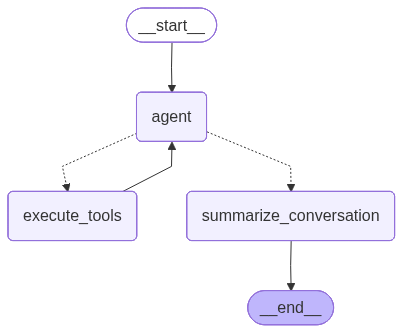

In [27]:
# Visualize the graph
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Test of the agent with interactive main loop
The `main()` loop provides a simple console-based REPL that uses the compiled graph to process user messages in an ongoing thread.

In [28]:
def main(thread_id: str = "book_flight", user_id: str = "demo_user"):
    """Main interaction loop for the travel agent"""

    print("Welcome to the Travel Assistant! (Type 'exit' to quit)")

    # RunnableConfig is used by LangGraph to pass runtime values into tools and checkpointer
    config = RunnableConfig(configurable={"thread_id": thread_id, "user_id": user_id})
    # Start with an empty runtime state; the checkpointer/Redis may repopulate from prior runs.
    state = RuntimeState(messages=[])

    while True:
        # Read user input
        user_input = input("\nYou (type 'quit' to quit): ")

        if not user_input:
            continue

        if user_input.lower() in ["exit", "quit"]:
            print("Thank you for using the Travel Assistant. Goodbye!")
            break

        # Append the human message to the runtime state
        state["messages"].append(HumanMessage(content=user_input))

        try:
            # Process user input through the graph. The graph updates and persists state via the checkpointer.
            for result in graph.stream(state, config=config, stream_mode="values"):
                state = RuntimeState(**result)

            logger.debug(f"# of messages after run: {len(state['messages'])}")

            # Find the most recent AI message, so we can print the response
            ai_messages = [m for m in state["messages"] if isinstance(m, AIMessage)]
            if ai_messages:
                message = ai_messages[-1].content
            else:
                # Fallback if no AIMessage produced
                logger.error("No AI messages after run")
                message = "I'm sorry, I couldn't process your request properly."
                # Add the error message to the state
                state["messages"].append(AIMessage(content=message))

            print(f"\nAssistant: {message}")

        except Exception as e:
            # Keep the loop alive and give user-friendly feedback on errors
            logger.exception(f"Error processing request: {e}")
            error_message = "I'm sorry, I encountered an error processing your request."
            print(f"\nAssistant: {error_message}")
            # Add the error message to the state
            state["messages"].append(AIMessage(content=error_message))

This interactive loop appends the user’s message to runtime state and executes the compiled graph for that turn. `graph.stream()` handles node invocation, checkpointer persistence, and yields serialized state snapshots.

Now, Let's launch the interactive chatbot:

In [29]:
try:
    user_id = input("Enter a user ID: ") or "demo_user"  # Collect user id for demo
    thread_id = input("Enter a thread ID: ") or "demo_thread"  # Collect thread id for demo
except Exception:
    # If we're running in CI, we don't have a terminal to input from, so just exit
    exit()
else:
    main(thread_id, user_id)

Enter a user ID: 123
Enter a thread ID: 123
Welcome to the Travel Assistant! (Type 'exit' to quit)

You (type 'quit' to quit): Hi I plan to go to singapore with my wife this summer. We love outdoors activities and trying new kinds of foods. Any good recommendations?

Assistant: That sounds like an exciting trip! Singapore offers a fantastic mix of outdoor activities and diverse food experiences. Here are some recommendations for you and your wife:

### Outdoor Activities:
1. **Hiking in MacRitchie Reservoir**: Enjoy scenic trails with beautiful views. The treetop walk offers a unique perspective of the forest canopy.
2. **Gardens by the Bay**: Explore the stunning gardens, including the iconic Supertree Grove and the Cloud Forest Dome. The outdoor areas are perfect for strolling and enjoying the scenery.
3. **Sentosa Island**: This resort island has beautiful beaches, adventure parks, and nature trails. You can relax on the beach or try activities like zip-lining and hiking.
4. **Cycli

References: This work is inspired by and builds upon the notebook 'agent_memory_tutorial.ipynb' demonstrated in the excellent 'agents-towards-production' repository of Nir Diamant